## Задание №2 по курсу Численное моделирование реагирующих потоков
#### Чернов Алексей, 335
### Структура детонационной волны Зельдовича–Неймана–Деринга

Смесь №1, метод Ньютона, Метод Гира 2-го порядка аппроксимации

#### Объявление констант:

In [1]:
GAMMA = 1.25
MU = 0.029
Q = 2.94e6
EA = 71e3
A = 1e9
P0 = 1e5
V0 = 0
R = 8.31
T = 293
RO0 = P0 * MU/(R * T)
EPS = 1e-6
DX = 1e-8

#### Объявление функций:

In [2]:
import numpy as np

def chapman_jouguet():
    dcj = ((GAMMA**2 - 1) * Q * 0.5 + GAMMA * P0/RO0)**0.5 + ((GAMMA**2 - 1) * Q * 0.5)**0.5
    pcj = P0/(GAMMA + 1) + RO0/(GAMMA + 1) * dcj**2
    rocj = (GAMMA + 1)/GAMMA * RO0**2 * dcj**2/(P0 + RO0 * dcj**2)
    tcj = pcj * MU/(R * rocj)
    return (rocj, dcj, pcj/P0, 0, tcj)

def c(p, ro):
    return (GAMMA * p/ro)**0.5

def runge_kutta(x):
    k_1 = f(x)
    k_2 = f(x + DX/2 * k_1)
    k_3 = f(x + DX/2 * k_2)
    k_4 = f(x + DX * k_3)
    x_rk = x + DX * (k_1 + 2 * k_2 + 2 * k_3 + k_4) / 6
    return x_rk

def f(x):
    ro, u, p, z = x
    f4 = -A * ro * z/u * np.exp(-ro * EA/(p * MU))
    f2 = -Q * u * (GAMMA - 1)/(c(p, ro)**2 - u**2) * f4
    f3 = -ro * u * f2
    f1 = -ro/u * f2
    return np.array([f1, f2, f3, f4])

def fi(x_, x_1, x_2): 
    return (1.5 * x_ - 2. * x_1 + 0.5 * x_2)/DX - f(x_)

def J(x): 
    J = np.array((np.zeros(4), np.zeros(4), np.zeros(4), np.zeros(4)))
    ro, u, p, z = x
    a1, a2, a3, a4 = f(x)
    J[0, 0] = 1.5/DX + a1 * (EA/(p * MU) - 2/ro)
    J[0, 1] = a1 * (1/u - 2 * u/(GAMMA * p/ro - u**2))
    J[0, 2] = -a1 * ro * EA/(p**2  *  MU)
    J[0, 3] = -a1/z
    J[1, 0] = a2 * (EA/(p * MU) - 1/ro)
    J[1, 1] = 1.5/DX - a2 * 2 * u/(GAMMA * p/ro)
    J[1, 2] = -a2 * ro * EA/p**2/MU
    J[1, 3] = -a2/z
    J[2, 0] = a3 * (EA/(p * MU) - 2/ro)
    J[2, 1] = a3 * (2 * u/(GAMMA * p/ro) - 1/u)
    J[2, 2] = 1.5/DX - a3 * ro * EA/p**2/MU
    J[2, 3] = -a3/z
    J[3, 0] = a4 * (EA/(p * MU) - 1/ro)
    J[3, 1] = -a4/u
    J[3, 2] = -a4 * ro * EA/p**2/MU
    J[3, 3] = 1.5/DX - a4/z
    return J

def newton(x, x_1): 
    dx = -np.dot(np.linalg.inv(J(x)), fi(x, x, x_1))
    x_next = x + dx
    while variance(dx, x_next) > EPS:
        dx = -np.dot(np.linalg.inv(J(x)), fi(x_next, x, x_1))
        x_next += dx
    return x_next

def variance(dx, x):
    s = 0.
    for i in range(4):
        s += (dx[i]/x[i])**2
    return s**0.5

def initialization(dcj):
    x = []
    x.append(np.array([RO0, 0, P0, 1]))
    p = 2 * RO0/(GAMMA + 1) * dcj**2 - (GAMMA - 1)/(GAMMA + 1) * P0
    u = dcj - (p - P0)/(RO0 * (0.5 * (GAMMA + 1) * p) + 0.5 * (GAMMA - 1) * P0)**0.5
    ro = RO0 * dcj/u
    z = 1
    x.append(np.array([ro, u, p, z]))
    return x

#### Расчет параметров

In [3]:
NAMES = ['ro', 'u', 'p', 'Z', 'T']
UNITS = ['kg/m3', 'm/s', 'atm', ' ' , 'K']

cj = chapman_jouguet()

print 'Chapman-Jouguet parameters:'
for i in [0,2,4]:
    print NAMES[i] + '_cj', '=', round(cj[i], 1), UNITS[i]

x_ = initialization(cj[1]) # cj[1] is D_cj
x_.append(runge_kutta(x_[1]))
itr = len(x_) - 1
ro, u, p, z = x_[itr]
while itr * DX * 1e3 < 0.07: # x < 0.07 mm
    itr += 1
    x_.append(newton(x_[itr - 1], x_[itr - 2]))
    ro, u, p, z = x_[itr]
for i in range(itr + 1):
    x_[i] = np.append(x_[i], x_[i][2] * MU/(x_[i][0] * R)) # T = p * MU/(ro * R)
    x_[i][2] /= P0

print '\nCalculated parameters (x =', itr * DX * 1e3, 'mm):'
for i in [0,2,4]:
    print NAMES[i], '=', round(x_[itr][i], 1), UNITS[i]

Chapman-Jouguet parameters:
ro_cj = 2.1 kg/m3
p_cj = 19.0 atm
T_cj = 3174.6 K

Calculated parameters (x = 0.07 mm):
ro = 2.1 kg/m3
p = 19.4 atm
T = 3184.9 K


#### Построение графиков

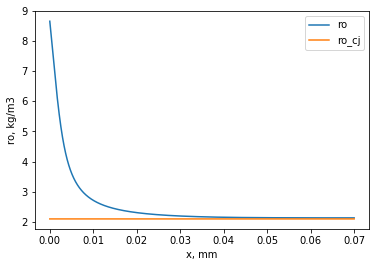

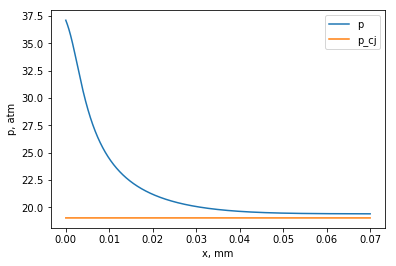

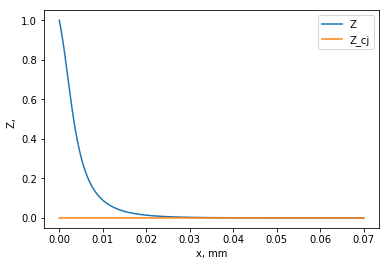

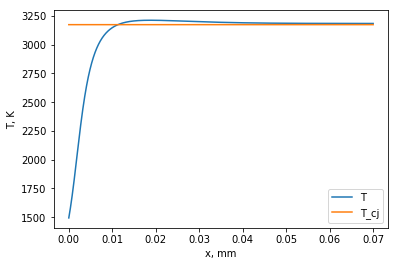

In [4]:
import matplotlib.pyplot as plt
for j in [0, 2, 3, 4]:
    X = len(x_) - 1
    a = [x_[i][j] for i in range(X)]
    a_cj = [cj[j] for i in range(X)]
    coord = [DX * i * 1e3 for i in range(X - 1)]
    plt.plot(coord, a[1:X], label = NAMES[j])
    plt.plot(coord, a_cj[1:X], label = NAMES[j] + '_cj')
    plt.ylabel(s = NAMES[j] + ', ' + UNITS[j])
    plt.xlabel(s = 'x, mm')
    plt.legend()
    plt.show()